## FRB130626

FRB verification criteria.

Criteria results:

* POSTIVE: good evidence for astrophysical origin
* NEUTRAL: neutral evidence
* UNKNOWN: unknown from reported data
* NEGATIVE: evidence for terrestrial origin (non-critical)
* CRITICAL: good evidence for terrestiral origin (critical)
* NOTVALID: not valid criterion for observation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
import cPickle as pkl

import astropy.time
import astropy.coordinates
import astropy.units

import dedispersion
import filterbankio
import frbutils
import scatterutils as scat

%matplotlib inline

/home/kat/ve/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 1.0})

In [3]:
criteria = {} # criteria status dictionary

### Parameters

[Five new Fast Radio Bursts from the HTRU high latitude survey: first evidence for two-component bursts - Champion et al.](https://arxiv.org/abs/1511.07746)

[Data Link](https://data-portal.hpc.swin.edu.au/dataset/fast-radio-burst-data-high-time-resolution-universe-survey-high-latitude)

Data Extraction:

```
boltflash:
cd /data2/griffin/FRB130626/01
header 2013-06-26-14:53:53.fil
extract 2013-06-26-14:53:53.fil 1875000 156250 > FRB130626_s120r10.fil
decimate -c 1 -t 1 -n 8 FRB130626_s120r10.fil > FRB130626_s120r10b8.fil
```

In [4]:
frbStr = 'FRB130626'
#frbFil = '/local/griffin/data/FRB/FRB130626/FRB130626_s120r10b8.fil' # Filterbank file of FRB event (aslxlap07)
frbFil = '/scratch/griffin/FRB/FRB130626_s120r10b8_b01.fil' # Filterbank file of FRB event (aslxlap07)

### Dynamic Spectrum (Component Optimized)

In [5]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 952.4

start_time = 6.7 # seconds
time_window = 0.14 # seconds

applyGauss = True
fGauss = 4. # bins
tGauss = 4. # bins

rfi = [[45,65], [155,175], [200,250], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [6]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

#### DM Excess

Using https://www.nrl.navy.mil/rsd/RORF/ne2001/

Galactic pointing: (l, b) = (7.45003, 27.4203)

In [7]:
DM_galaxy = 66.87
DM_excess = dm / DM_galaxy
print 'DM Excess fraction:', DM_excess

criteria['compDMfrac'] = 'POSITIVE'
criteria['snrDMfrac'] = 'NOTVALID'

DM Excess fraction: 14.2425601914


#### TIme Series

In [8]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)

#### Stokes I Plot

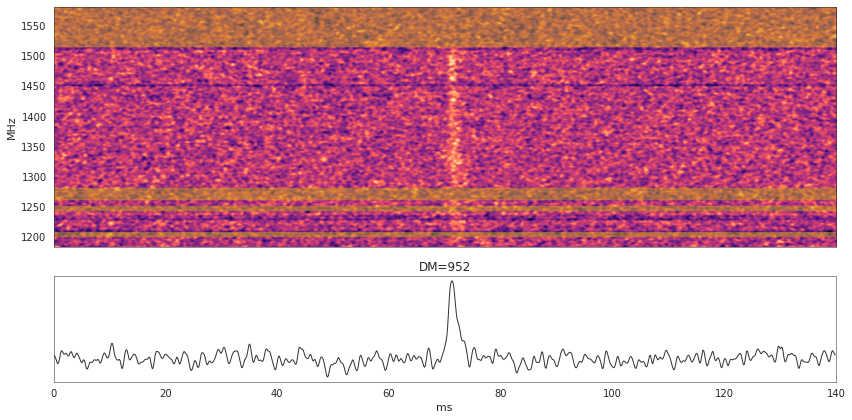

In [9]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
# crop out RFI flagged high freqs
#imRaw = plt.imshow(np.flipud(decddwaterfall[:,:850].T), extent=(0, tInt*decddwaterfall.shape[0],\
#                        freqs[0], freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig('%s_dynamic.png'%frbStr)

#### Signal to Noise

In [10]:
SNR = (ddTimeSeries.max() - ddTimeSeries.mean()) / ddTimeSeries.std()
print 'S/N:', SNR
criteria['SNR'] = 'POSITIVE' # high S/N across the band

S/N: 8.38041871728266


#### Boresight Flux

In [11]:
SEFD = 30. # Jy, approximate SEFD of Parkes L-band
flux = frbutils.flux(SEFD, SNR, 1, 2, tInt, (freqs[-1]-freqs[0])*1e6)
print 'flux: %f Jy'%flux
criteria['flux'] = 'POSITIVE' # high S/N across the band

flux: 1.111640 Jy


#### Components

[[Model]]
    (Model(constant) + Model(gaussian, prefix='nc0'))
[[Fit Statistics]]
    # function evals   = 646
    # data points      = 700
    # variables        = 4
    chi-square         = 453.885
    reduced chi-square = 0.652
    Akaike info crit   = -295.266
    Bayesian info crit = -277.062
[[Variables]]
    c:              148.304633 +/- 0.032187 (0.02%) (init= 0)
    nc0sigma:       0.84930796 +/- 0.019258 (2.27%) (init= 6)
    nc0center:      20.2734400 +/- 0.018908 (0.09%) (init= 70)
    nc0amplitude:   22.5159440 +/- 0.457818 (2.03%) (init= 1)
    nc0fwhm:        1.99996737 +/- 0.045350 (2.27%)  == '2.3548200*nc0sigma'
    nc0height:      10.5763314 +/- 0.205186 (1.94%)  == '0.3989423*nc0amplitude/max(1.e-15, nc0sigma)'
[[Correlations]] (unreported correlations are <  0.100)
    C(nc0sigma, nc0amplitude)    =  0.598 
    C(c, nc0amplitude)           = -0.317 
    C(c, nc0sigma)               = -0.190 

NCOMPONENTS: 1
FWHM0 (ms): 1.99996737185


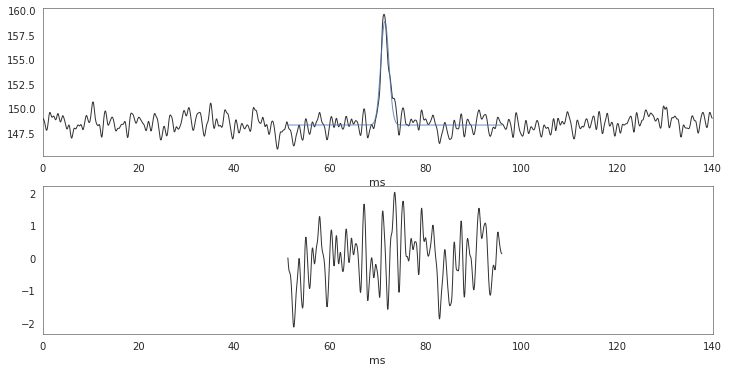

In [12]:
# Assume pulse can be modelled as a set of Gaussian components on a constant offset
nComponents = 1 # number of components in pulse

pulseModel = lmfit.models.ConstantModel()
for nc in np.arange(nComponents):
    gaussComp = lmfit.models.GaussianModel(prefix='nc%i'%nc)
    pulseModel += gaussComp

#print pulseModel
params = pulseModel.make_params(nc0center=70., nc0sigma=6)

#select only region around pulse for fit
tIdx0 = 800
tIdx1 = 1500
ddTimeSeriesCent = ddTimeSeries[tIdx0:tIdx1]
result = pulseModel.fit(ddTimeSeriesCent, params, x=1000.*tInt*np.arange(ddTimeSeriesCent.shape[0]))
print result.fit_report()

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot(2,1,1)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(ddTimeSeries.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.plot(1000.*tInt*(np.arange(ddTimeSeriesCent.shape[0])+tIdx0), result.best_fit, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.xlabel('ms')

ax2 = plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(1000.*tInt*(np.arange(ddTimeSeriesCent.shape[0])+tIdx0), ddTimeSeriesCent - result.best_fit,\
         lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.xlabel('ms')

print 'NCOMPONENTS:', nComponents
for nc in np.arange(nComponents):
    print 'FWHM%i (ms):'%nc, result.params['nc%ifwhm'%nc].value

criteria['pulsewidth'] = 'POSITIVE' # good fit to a Gaussian model
criteria['multicomp'] = 'POSITIVE' # single component

### Polarization

In [13]:
criteria['polarization'] = 'NOTVALID' # not recorded

### Spectral Index

In [14]:
# upper and lower frequency of pulse
# if pulse goes to the edge of beam, set to None
upperFreqMHz = freqs[-1]
lowerFreqMHz = freqs[0]
obsFracBand = (freqs[-1]-freqs[0]) / ((freqs[-1]+freqs[0])/2.) # observational fractional bandwidth
print 'START OBS FREQ (MHz):', freqs[0]
print 'STOP OBS FREQ (MHz):', freqs[-1]
print 'BANDWIDTH (MHz):', freqs[-1]-freqs[0]
print 'FRACTIONAL OBS BANDWIDTH:', obsFracBand
print 'FRACTIONAL PULSE BANDWIDTH:', (upperFreqMHz - lowerFreqMHz) / ((upperFreqMHz+lowerFreqMHz)/2.)

criteria['broadband'] = 'POSITIVE'

START OBS FREQ (MHz): 1182.1953125
STOP OBS FREQ (MHz): 1581.8046875
BANDWIDTH (MHz): 399.609375
FRACTIONAL OBS BANDWIDTH: 0.2891529486251809
FRACTIONAL PULSE BANDWIDTH: 0.2891529486251809


In [15]:
# region to use for spectral index fit

# select between freq limits
upperFreqIdx = np.argmin(np.abs(freqs - upperFreqMHz))
lowerFreqIdx = np.argmin(np.abs(freqs - lowerFreqMHz))

# select around peak
peakIdx = np.unravel_index(np.argmax(decddwaterfall), decddwaterfall.shape)
tWidth = 10 # number of time stample to take on eiter side of peak

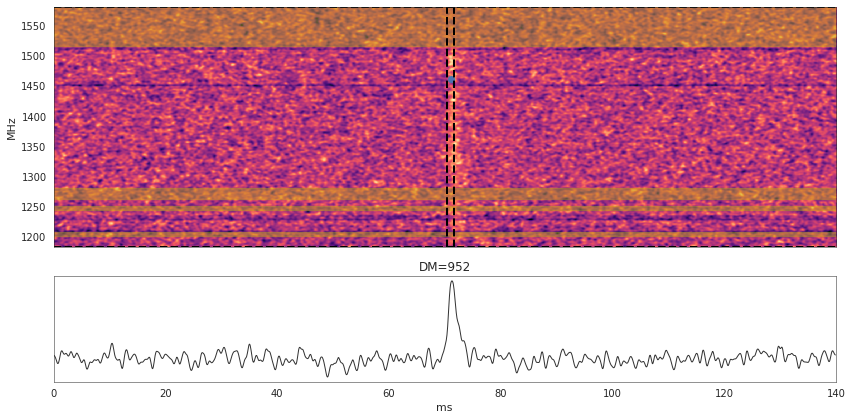

In [16]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
# crop out RFI flagged high freqs
#imRaw = plt.imshow(np.flipud(decddwaterfall[:,:850].T), extent=(0, tInt*decddwaterfall.shape[0],\
#                        freqs[0], freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')
plt.axhline(y=upperFreqMHz, c='k', lw=2, ls='--')
plt.axhline(y=lowerFreqMHz, c='k', lw=2, ls='--')
plt.scatter(tInt*peakIdx[0], freqs[peakIdx[1]])
plt.axvline(x=tInt*(peakIdx[0]-tWidth), c='k', lw=2, ls='--')
plt.axvline(x=tInt*(peakIdx[0]+tWidth), c='k', lw=2, ls='--')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()

[[Model]]
    (Model(constant) + Model(powerlaw))
[[Fit Statistics]]
    # function evals   = 8004
    # data points      = 760
    # variables        = 3
    chi-square         = 24673.098
    reduced chi-square = 32.593
    Akaike info crit   = 2650.914
    Bayesian info crit = 2664.814
[[Variables]]
    c:          -1752.40650 +/- 2.08e+05 (11892.30%) (init= 0)
    exponent:    0.02060882 +/- 2.251370 (10924.31%) (init= 1)
    amplitude:   1239.87725 +/- 1.94e+05 (15618.35%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(c, amplitude)              = -1.000 
    C(exponent, amplitude)       = -1.000 
    C(c, exponent)               =  1.000 

SPECTRAL INDEX: 0.020608822556114823


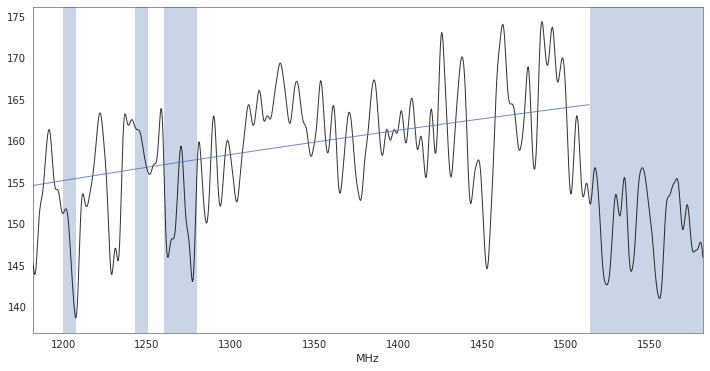

In [17]:
spectralRaw = decddwaterfall[peakIdx[0]-tWidth:peakIdx[0]+tWidth].mean(axis=0)

vaildFreqMask = np.zeros_like(spectralRaw)
vaildFreqMask[lowerFreqIdx:upperFreqIdx] = 1.
for freqPair in rfi:
    vaildFreqMask[freqPair[0]:freqPair[1]] = 0.

spectralModel = lmfit.models.ConstantModel() + lmfit.models.PowerLawModel()
spectralParams = spectralModel.make_params()
spectralResult = spectralModel.fit(spectralRaw[vaildFreqMask.astype(bool)],\
                                   spectralParams, x=freqs[vaildFreqMask.astype(bool)]*1e6)
print spectralResult.fit_report()

fig = plt.figure(figsize=(12,6)) # (width, height)

lineColor = 'k'
plt.plot(freqs, spectralRaw, lineColor, alpha=0.8)
plt.plot(freqs[vaildFreqMask.astype(bool)], spectralResult.best_fit, alpha=0.8)

plt.axvspan(freqs[0], freqs[lowerFreqIdx], alpha=0.3)
plt.axvspan(freqs[upperFreqIdx], freqs[-1], alpha=0.3)
for freqPair in rfi:
    plt.axvspan(freqs[freqPair[0]/freqFactor], freqs[freqPair[1]/freqFactor], alpha=0.3)

plt.xlabel('MHz')
plt.xlim(freqs[0], freqs[-1])

print 'SPECTRAL INDEX:', spectralResult.params['exponent'].value
criteria['spectralIndex'] = 'POSITIVE' # consistent spectral index fit across the usable band

### High-resolution Structure

In [18]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 952.4

start_time = 6.7 # seconds
time_window = 0.14 # seconds

applyGauss = True
fGauss = 1. # bins
tGauss = 1. # bins

rfi = [[45,65], [155,175], [200,250], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [19]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

In [20]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)

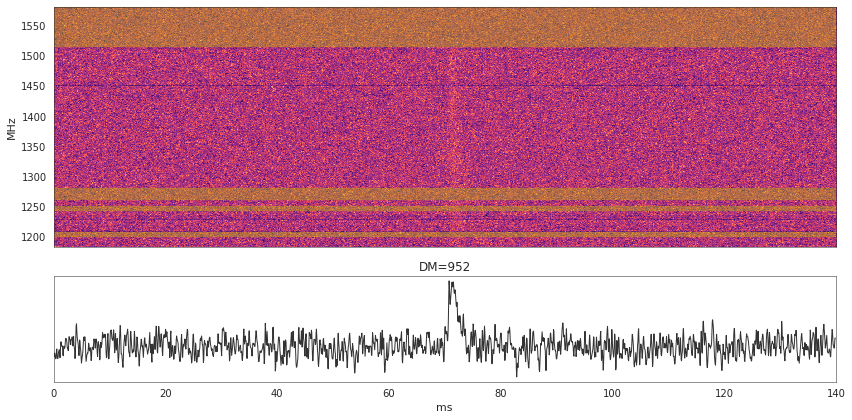

In [21]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()

In [22]:
criteria['highResStruct'] = 'POSITIVE' # no apparent structure

### Scattering

* compute scatter timescale in time series

In [35]:
### Write dynamic spectrum to ascii file using a pdv-like method (writePDVtimeSeries)
### nch determines the number of channels to which a scattering time (tau value) is fitted
pdvfilen = '%s.ascii' %frbFil
pdvfile = scat.writePDVtimeSeries(decddwaterfall, freqs, time_window, nch=4, src='FRB', ofn=pdvfilen) 

In [2]:
#pdvfilen = '/scratch/griffin/FRB/FRB130626_s120r10b8_b01.fil.ascii'

Pulsar name: FRB
Number of channels: 4
Number of bins: 2187
RMS: 0.212546
Using Tsub in header to convert bins to time. Note Tsub here is full phase time, corresponding to nbins.

 Channel 0
peak bin at lowest freq channel:1133
Rolling data by --39 bins
[[Model]]
    Model(GxETrain)
[[Fit Statistics]]
    # function evals   = 243
    # data points      = 2187
    # variables        = 5
    chi-square         = 82.061
    reduced chi-square = 0.038
    Akaike info crit   = -7169.531
    Bayesian info crit = -7141.080
[[Variables]]
    mu:      1086.87156 +/- 495.6581 (45.60%) (init= 1094)
    sigma:   14.1638216 +/- 26.28614 (185.59%) (init= 15)
    A:       1.35693274 +/- 1.32e+03 (97029.03%) (init= 0.647829)
    tau:     0.60958158 +/- 610.3943 (100133.32%) (init= 200)
    dc:     -0.07227552 +/- 0.004220 (5.84%) (init= 0)
    nbins:   2187 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(A, tau)                    = -1.000 
    C(mu, tau)                   = -1.0

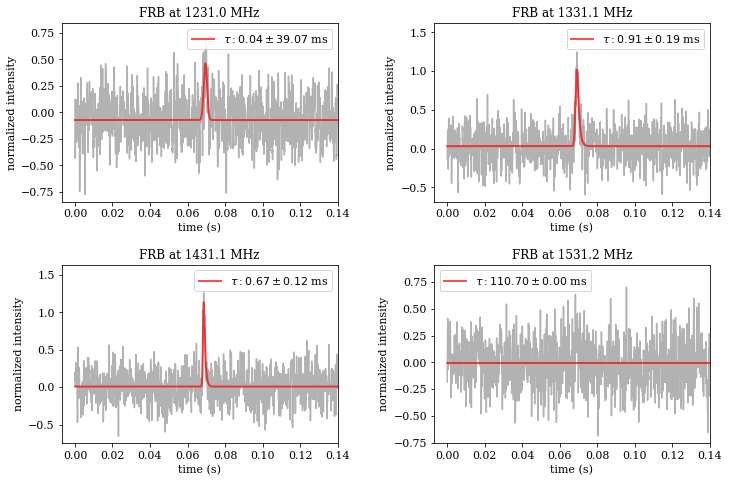

Tau (ms): 0.04
tau1GHz_alpha_4 (ms) ~ 0.09 

Tau (ms): 0.91
tau1GHz_alpha_4 (ms) ~ 2.85 

Tau (ms): 0.67
tau1GHz_alpha_4 (ms) ~ 2.82 

Tau (ms): 110.70
tau1GHz_alpha_4 (ms) ~ 608.47 



In [3]:
### produce_taufits 
### provides lmfit scattering fits (using intrinsic Gaussian shape) for each 'nch'
### method='iso' uses the standard ISM broadening function propto (1/tau)e^(-t/tau)

freqMHz, taus, tauserr = scat.produce_taufits(pdvfilen,meth='iso')

In [30]:
tauserr_nonzero = tauserr[np.nonzero(tauserr)]

array([0.03907417, 0.00018559, 0.00011972])

In [34]:
taus = taus[np.nonzero(tauserr)]
taus

array([3.90221409e-05, 9.06473379e-04, 6.71741992e-04])

see:
[0.03907417 0.00018559 0.00011972]
[3.90221409e-05 9.06473379e-04 6.71741992e-04]
[[Variables]]
    exponent:   -4.13444050 +/- 0.000478 (0.01%) (init= 32.17087)
    amplitude:   0.00295695 +/- 4.84e-07 (0.02%) (init= 4.365511e-08)
[[Correlations]] (unreported correlations are <  0.100)
    C(exponent, amplitude)       = -0.996 


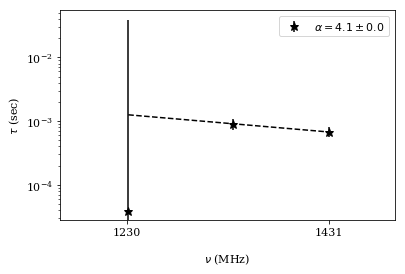

In [4]:
### produce_tauspectrum
### lmfit power law fit (weighted: 1/tauerr^2) for all non-zero tauerr
import scatterutils as scat
alpha, alphaerr = scat.produce_tauspectrum(freqMHz, taus, tauserr)

In [27]:
criteria['scattering'] = 'NOTVALID'

### Scintillation

* compute characteristic scintillation bandwidth, FFT of spectrum (function)

In [28]:
criteria['scintillation'] = 'NOTVALID'

### DM Trial Space

In [29]:
# High-res
timeFactor = 8

minDM = 935
maxDM = 965
dmStep = 0.2

start_time = 6. # seconds
time_window = 1.5 # seconds

applyGauss = True
fGauss = 1. # bins
tGauss = 1. # bins

rfi = [[45,65], [155,175], [200,250], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [30]:
dmSpaceArr, tInt, freqs = frbutils.dmSpace(frbFil, start_time, time_window,
                                          minDM, maxDM, dmStep, timeFactor, rfi=rfi)

Maximum delay (ms) based on maximum DM (965.000000): 1264.925462252356


Text(0.5,0,u't (ms)')

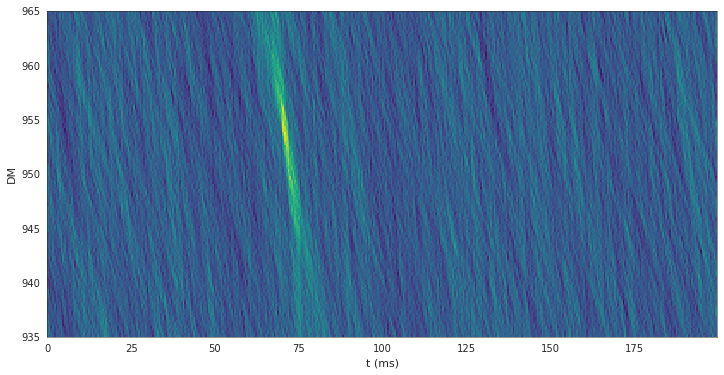

In [31]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 700. # (start) ms
tClipHigh = 200. # (width) ms
plt.imshow(np.flipud(dmSpaceArr[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

In [32]:
# Low-res
timeFactor = 8

minDM = -1500
maxDM = 1500
dmStep = 8

start_time = 4.5 # seconds
time_window = 3. # seconds

applyGauss = True
fGauss = 1. # bins
tGauss = 1. # bins

rfi = [[45,65], [155,175], [200,250], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [33]:
dmSpaceArrLow, tInt, freqs = frbutils.dmSpace(frbFil, start_time, time_window,
                                          minDM, maxDM, dmStep, timeFactor, rfi=rfi)

Maximum delay (ms) based on maximum DM (1500.000000): 1966.2053817394137


Text(0.5,0,u't (ms)')

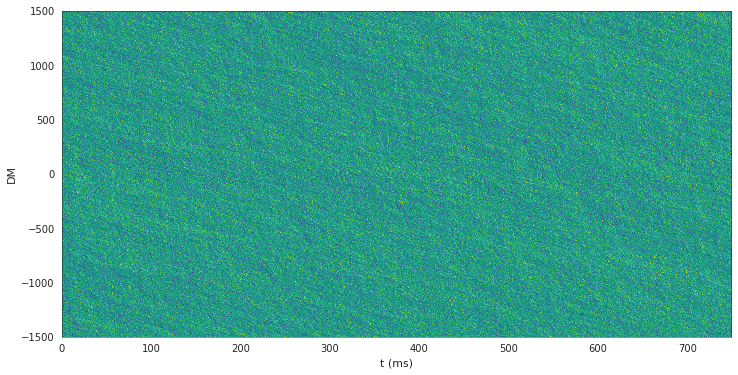

In [34]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 0. # (start) ms
tClipHigh = 750. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

Text(0.5,0,u't (ms)')

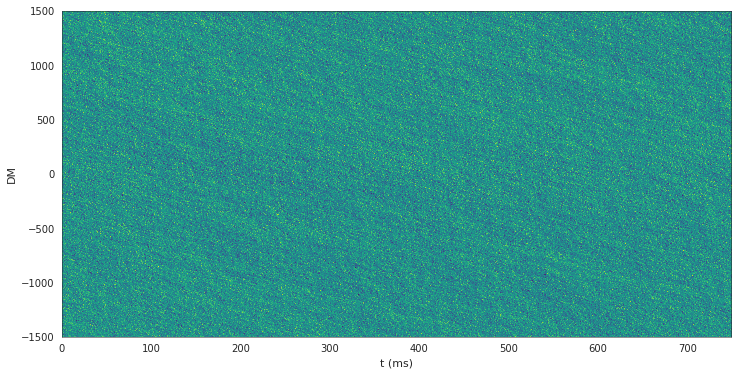

In [35]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 750. # (start) ms
tClipHigh = 750. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

Text(0.5,0,u't (ms)')

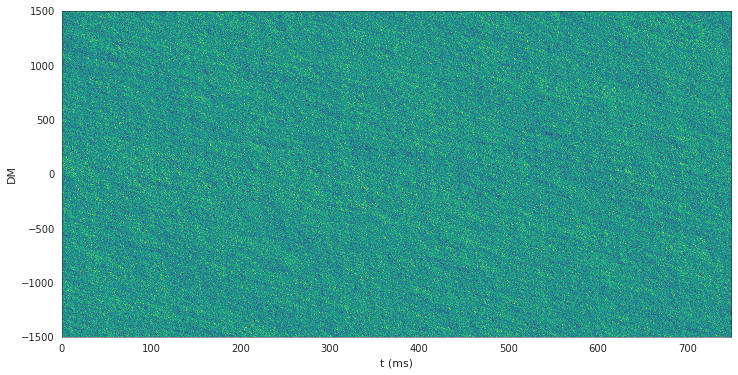

In [36]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 1500. # (start) ms
tClipHigh = 750. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

Text(0.5,0,u't (ms)')

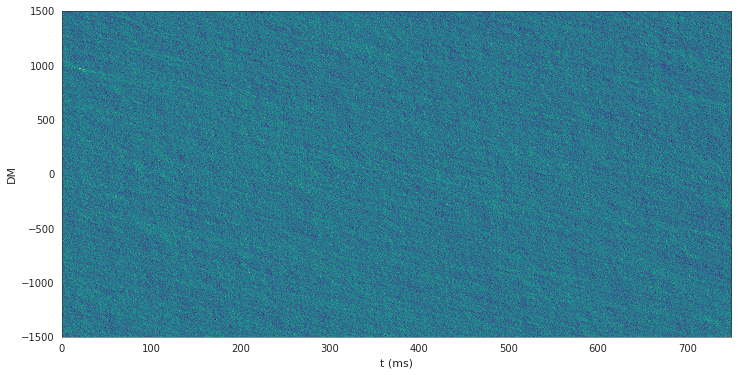

In [37]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 2250. # (start) ms
tClipHigh = 750. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

In [38]:
# No other bright regions in the DM trial space
# No obvious bias in positive or negative DM trial
criteria['dmSpace'] = 'POSITIVE'

### Dispersion Relation

In [ ]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 952.4

start_time = 6.7 # seconds
time_window = 1.5 # seconds

applyGauss = True
fGauss = 4. # bins
tGauss = 4. # bins

rfi = [[45,65], [155,175], [200,250], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

normalize = False

In [ ]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

In [ ]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)
startIdx = np.argmax(ddTimeSeries)
startTime = startIdx * tInt # seconds

In [ ]:
if normalize:
    meanGain = np.median(decwaterfall, axis=1)
    decwaterfall = decwaterfall / meanGain[:, None]

    meanBP = np.mean(decwaterfall, axis=0)
    decwaterfall = decwaterfall / meanBP[None, :]

In [ ]:
# Find peaks in dedispersed dynamic spectrum
# assuming a near nu^-2 relation, but pick a wide region to allow for variation
peakSearchWidth = .02 # s, time width to find peaks
peakStartTime = startTime - (peakSearchWidth / 2.)
peakStartIdx = int(peakStartTime / tInt)
peakStopTime = startTime + (peakSearchWidth / 2.)
peakStopIdx = int(peakStopTime / tInt)
print peakStartIdx, peakStopIdx

cutoutDynamicSpectrum = np.copy(decddwaterfall[peakStartIdx:peakStopIdx].T)
cutoutDynamicSpectrum -= np.mean(cutoutDynamicSpectrum)

snrThresh = 3.
stdDSpec = np.std(cutoutDynamicSpectrum)

delays = dedispersion.delay(freqs * 1e6, dm) # seconds
#print delays

binaryMask = np.where(cutoutDynamicSpectrum > snrThresh * stdDSpec, 0.5, 0)

validFidx = []
validTidx = []
validDelays = []
validSNR = []

for fIdx in np.arange(cutoutDynamicSpectrum.shape[0]): # loop over frequency channels
    subband = cutoutDynamicSpectrum[fIdx]
    # select only pixels above a threshold
    subPeakIdx = np.argmax(subband)
    if (subband[subPeakIdx] > snrThresh * stdDSpec):
        binaryMask[fIdx, subPeakIdx] = 1.
        validFidx.append(fIdx)
        validTidx.append(subPeakIdx)
        validSNR.append(subband[subPeakIdx] / stdDSpec)

validFreqs = freqs[validFidx]
validDelays = (np.array(validTidx) * tInt) - (peakSearchWidth / 2.) + delays[validFidx] + startTime
validSNR = np.array(validSNR)
#print validFreqs # MHz
#print validDelays # seconds
#print validSNR

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(binaryMask), extent=(0, tInt*cutoutDynamicSpectrum.shape[1],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('MHz')
plt.xlabel('s')

In [ ]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(cutoutDynamicSpectrum), extent=(0, tInt*cutoutDynamicSpectrum.shape[1],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')
plt.xlabel('s')

In [ ]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,9)) # (width, height)

ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)

plt.scatter(validDelays, validFreqs)

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((5, 3), (2, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.axvline(x=peakStartTime, c='k', lw=2, ls='--')
plt.axvline(x=peakStopTime, c='k', lw=2, ls='--')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

ax2.get_xaxis().set_visible(False)

ax3 = plt.subplot2grid((5, 3), (4, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax3.get_yaxis().set_visible(False)

plt.tight_layout()

#### Build Power Law Model

In [ ]:
model = lmfit.models.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff', independent_vars=['nu1', 'nu2'])

print model
print model.param_names
print model.independent_vars

In [ ]:
nu1 = validFreqs.copy()
nu2 = np.ones_like(validFreqs) * freqs[-1]

In [ ]:
params = model.make_params(amp=dm * 4.148808e3, alpha=-2., toff=-1.*startTime)
#params['alpha'].set(min=-2.5, max=-1.5)
print params

In [ ]:
#print model.eval(params, nu1=nu1, nu2=nu2)
#print validDelays

In [ ]:
out  = model.fit(validDelays, params, nu1=nu1, nu2=nu2, weights=validSNR)
print out.fit_report()

In [ ]:
alphaBest = out.best_values['alpha']
ampBest = out.best_values['amp']
toffBest = out.best_values['toff']
nu1Full = freqs
nu2Full = freqs[-1]

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)
plt.plot(ampBest * (nu1Full**(alphaBest) - nu2Full**(alphaBest)) - toffBest, freqs)


plt.scatter(validDelays, validFreqs)

plt.tight_layout()

In [ ]:
# Fits well to a nu^-2 dispersion relation
criteria['dispersionRelation'] = 'POSITIVE'

### Telescope Response

In [ ]:
offFrbFil = '/local/griffin/data/FRB/FRB130626/difftime/FRB130626_s0r10b8.fil' # beam 1, ~2 minutes earlier

onFil = filterbankio.Filterbank(frbFil)
ontInt = onFil.header['tsamp'] # get tInt
onFreqsHz = onFil.freqs * 1e6 # generate array of freqs in Hz
onFreqs = onFreqsHz / 1e6 # MHz
onWaterfall = np.reshape(onFil.data, (onFil.data.shape[0], onFil.data.shape[2]))

offFil = filterbankio.Filterbank(offFrbFil)
offtInt = offFil.header['tsamp'] # get tInt
offFreqsHz = offFil.freqs * 1e6 # generate array of freqs in Hz
offWaterfall = np.reshape(offFil.data, (offFil.data.shape[0], offFil.data.shape[2]))

In [ ]:
# Bandpass

onMeanBP = onWaterfall.mean(axis=0)
onMinBP = onWaterfall.min(axis=0)
onMaxBP = onWaterfall.max(axis=0)
onMedianBP = np.median(onWaterfall, axis=0)

offMeanBP = offWaterfall.mean(axis=0)
offMinBP = offWaterfall.min(axis=0)
offMaxBP = offWaterfall.max(axis=0)
offMedianBP = np.median(offWaterfall, axis=0)

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

plt.plot(onFreqs, onMeanBP, 'g-')
plt.plot(onFreqs, onMedianBP, 'g--')
#plt.plot(onFreqs, onMinBP, 'g.')
#plt.plot(onFreqs, onMaxBP, 'g.-')
plt.fill_between(onFreqs, onMinBP, onMaxBP, color='g', alpha=0.2)

plt.plot(onFreqs, offMeanBP, 'b-')
plt.plot(onFreqs, offMedianBP, 'b--')
#plt.plot(onFreqs, offMinBP, 'b.')
#plt.plot(onFreqs, offMaxBP, 'b.-')

plt.xlim(onFreqs[0], onFreqs[-1])
plt.xlabel('Mhz')

plt.tight_layout()

In [ ]:
criteria['bandpass'] = 'UNKNOWN' # data has been bandpass normalized

In [ ]:
# Gain

onMeanGain = onWaterfall.mean(axis=1)
onMinGain = onWaterfall.min(axis=1)
onMaxGain = onWaterfall.max(axis=1)
onMedianGain = np.median(onWaterfall, axis=1)

offMeanGain = offWaterfall.mean(axis=1)
offMinGain = offWaterfall.min(axis=1)
offMaxGain = offWaterfall.max(axis=1)
offMedianGain = np.median(offWaterfall, axis=1)

tRange = np.arange(onMeanGain.shape[0]) * ontInt

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

plt.plot(tRange, onMeanGain, 'g-')
#plt.plot(onFreqs, onMedianGain, 'g--')
#plt.plot(onFreqs, onMinGain, 'g.')
#plt.plot(onFreqs, onMaxGain, 'g.-')
#plt.fill_between(onFreqs, onMinGain, onMaxGain, color='g', alpha=0.2)

plt.plot(tRange, offMeanGain, 'b-')
#plt.plot(onFreqs, offMedianGain, 'b--')
#plt.plot(onFreqs, offMinGain, 'b.')
#plt.plot(onFreqs, offMaxGain, 'b.-')

plt.xlim(0, onMeanGain.shape[0] * ontInt)
plt.xlabel('s')

plt.tight_layout()

In [ ]:
criteria['gain'] = 'UNKNOWN' # data has been gain normalized

### Telescope State

In [ ]:
# Telescope pointing

eventUTCStr = '2013-06-26 14:55:59.771'
eventUTC = astropy.time.Time(eventUTCStr)
print eventUTC

eventGall = 7.45003
eventGalb = 27.4203

galCoords = astropy.coordinates.SkyCoord(eventGall, eventGalb, frame=astropy.coordinates.Galactic,\
                                         unit='deg', equinox='J2000')
print galCoords

# Parkes location
# https://www.parkes.atnf.csiro.au/observing/documentation/user_guide/pks_ug_2.html
siteLat = -32.99778
siteLong = 148.26292
siteLoc = astropy.coordinates.EarthLocation(lat=siteLat * astropy.units.deg, lon=siteLong * astropy.units.deg,\
                                  height=414.80 * astropy.units.m)
print siteLoc

print galCoords.transform_to(astropy.coordinates.AltAz(obstime=eventUTC, location=siteLoc))

print galCoords.transform_to('icrs')

criteria['lowAltitude'] = 'NEUTRAL' # mid-altitude pointing

In [ ]:
criteria['sysNoise'] = 'UNKNOWN' # system noise nominal?
criteria['correctFeed'] = 'UNKNOWN' # was the feed in the corrct position?
criteria['obsLog'] = 'UNKNOWN' # was the observation log checked to be nominal?
criteria['electronics'] = 'UNKNOWN' # were the correct electornics on? were other systems off?

### Follow-Up Observations

In [ ]:
# Unknown if follow-up observations or a pulsar search were done
criteria['repeats'] = 'UNKNOWN'
criteria['lowSNRsearch'] = 'UNKNOWN'

### Multi-Beam

In [ ]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 952.4

start_time = 6.7 # seconds
time_window = 0.14 # seconds

applyGauss = True
fGauss = 4. # bins
tGauss = 4. # bins

rfi = [[45,65], [155,175], [200,250], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [ ]:
def multiBeamPlot():
    decwaterfallBeam, decddwaterfallBeam, tInt, freqs = frbutils.dynamicSpectrum(frbFilBeam,
                                          start_time, time_window,
                                          timeFactor=timeFactor, freqFactor=freqFactor,
                                          dm=dm,
                                          applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                          rfi=rfi)

    ddTimeSeriesBeam = np.mean(decddwaterfallBeam, axis=1)

    cmap = 'magma'
    sns.set_style('white', rc={'axes.linewidth': 0.5})

    fig = plt.figure(figsize=(12,6)) # (width, height)

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

    imRaw = plt.imshow(np.flipud(decddwaterfallBeam.T), extent=(0, tInt*decddwaterfallBeam.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
    # crop out RFI flagged high freqs
    #imRaw = plt.imshow(np.flipud(decddwaterfallBeam[:,:850].T), extent=(0, tInt*decddwaterfallBeam.shape[0],\
    #                    freqs[0], freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

    for rfiPair in rfi:
        plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
    plt.ylabel('MHz')

    ax1.get_xaxis().set_visible(False)

    ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
    lineColor = 'k'
    plt.plot(1000.*tInt*np.arange(decddwaterfallBeam.shape[0]), ddTimeSeriesBeam, lineColor, alpha=0.8)
    plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, 'r', alpha=0.4) # pulse time series
    plt.xlim(0, 1000.*tInt*ddTimeSeriesBeam.shape[0])
    plt.title('DM=%0.f'%dm)
    plt.xlabel('ms')
    ax2.get_yaxis().set_visible(False)

    plt.tight_layout()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b01.fil' # beam 01 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b02.fil' # beam 02 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b03.fil' # beam 03 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b04.fil' # beam 04 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b05.fil' # beam 05 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b06.fil' # beam 06 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b07.fil' # beam 07 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b08.fil' # beam 08 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b09.fil' # beam 09 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b10.fil' # beam 10 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b11.fil' # beam 11 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b12.fil' # beam 12 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB130626/otherbeams/FRB130626_s120r10b8_b13.fil' # beam 13 (aslxlap07)
multiBeamPlot()

In [ ]:
# No pulse present in any of the other beams
criteria['multiBeam'] = 'POSITIVE'

### Tied-Array Beam

In [ ]:
criteria['TAB'] = 'NOTVALID'

### Interferometric Observations

In [ ]:
criteria['interferometric'] = 'NOTVALID'

### Multi-Site

In [ ]:
criteria['multiSite'] = 'NOTVALID'

### Available Data

In [ ]:
criteria['dataSingleBeam'] = 'NOTVALID'
criteria['dataMultiBeam'] = 'NEUTRAL' # filterbanks have been normalized
criteria['dataTAB'] = 'NOTVALID'
criteria['dataInterferometric'] = 'NOTVALID'
criteria['dataMultiSite'] = 'NOTVALID'
criteria['dataVoltages'] = 'NOTVALID'

### Report Output

In [ ]:
for key in criteria.iterkeys():
    print '%s: %s'%(key, criteria[key])

outFn = 'criteria.%s.pkl'%frbStr
ofh = open(outFn, 'wb')
pkl.dump(criteria, ofh)
ofh.close()